In [1]:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
%matplotlib inline

In [2]:
import bornagain as ba
from bornagain import deg, angstrom

In [3]:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

In [4]:
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH
print(Q_VALUES[0],Q_VALUES[-1])
#Location of the files to write and read the simulated data:
BornAgainLipidFile="./SandwichModel-BornAgain.dat"
RefnxLipidFile="./SandwichModel-Lipid-Refnx.dat"
import LipidBilayer as lip
xpar = lip.SampleParameters()

0.0 2.1821273570707342


In [5]:
def save_text_file(x,y, filename):
    intensity = y
    x_axis = x
    array_to_export = np.column_stack((x_axis, intensity))
    np.savetxt(filename,array_to_export)
    return

def comparison_plot(datafile, 
                    refnx_sim_file, 
                    ba_sim_file, 
                    title="", shift = 0.0,
                    nrows=2, ncols=2, datasets_per_plot=3,
                    I = 0, J = 0,
                    fig = None, axs = None, inset = None):
    """
    Given a fit (through the fit_objective), save a plot
    to visually compare it with the original data.
    The plot will be saved in the directory containing this
    script.
    """
    FigSize = 20
    FontSize = 20
    BorderWidth = 3
    if (fig is None) and (axs is None):
        plt.rcParams.update({'font.size': FontSize})
        plt.rcParams.update({'axes.linewidth': BorderWidth})    
        fig, axs = plt.subplots(nrows, ncols, figsize=(FigSize,FigSize))#,sharex=True,sharey=True)
        inset = {}
        
    if ncols * nrows < 2:
        axs = np.atleast_2d(np.array(axs))
    
    # Real data points (Q space):
    Xdata = np.loadtxt(datafile)[:,0]
    Ydata = np.loadtxt(datafile)[:,1]
    try:
        erbar = np.loadtxt(datafile)[:,2]
    except:
        erbar = np.zeros_like(Ydata)
    
    # Refnx model data ():
    Xrfnx = np.loadtxt(refnx_sim_file)[:,0]
    Yrfnx = np.loadtxt(refnx_sim_file)[:,1]
    
    # Bornagain model data:
    Xsimu = np.loadtxt(ba_sim_file)[:,0]#np.array(datasim.getAxis(0).getBinCenters())
    Ysimu = np.loadtxt(ba_sim_file)[:,1]#np.array(datasim.getAxis(0).getBinCenters())#datasim.getArray()
    
    #Refnx-Bornagain models difference:
    refnx_ba_diff  = 2.*np.abs(Yrfnx-Ysimu)/np.abs(Yrfnx+Ysimu)
    mean_diff = refnx_ba_diff.mean()
    
    #data:
    axs[I,J].tick_params(width=BorderWidth, length=0.3*FontSize, which='major')
    axs[I,J].tick_params(width=BorderWidth, length=0.3*FontSize, which='minor')
    base_line = axs[I,J].errorbar(Xdata, Ydata*shift, yerr=erbar*shift, 
                      linewidth = 0.1*FontSize, 
                      linestyle = ':',
                      marker = '.',
                      markersize=0.1*FontSize, 
                      label = "Data")
    current_color=base_line.lines[0].get_color()

    #refnx fit:
    axs[I,J].errorbar(Xrfnx, Yrfnx*shift, 
                      color = current_color, 
                      linewidth = 0.2*FontSize,
                      ls = '--',
                      markersize=FontSize, 
                      label = "Refnx")
    
    #bornagain simulation:
    axs[I,J].errorbar(Xsimu, Ysimu*shift, 
                      color = current_color, 
                      linewidth = 0.2*FontSize,
                      ls = '-',
                      markersize=FontSize, 
                      label = "BornAgain")

    # CURRENT INSET:
    if not (I,J) in inset.keys():
        inset[(I,J)] = inset_axes(axs[I,J],
                        width="30%",
                        height="30%",
                        )
    current_inset = inset[(I,J)]
    current_inset.semilogy(Xsimu, refnx_ba_diff,'.', color = current_color, label = "Relative Error", alpha = 0.3)
    current_inset.axhline(y=mean_diff,color=current_color,ls='--', label="Mean Relative Error = $" + str(np.round(mean_diff,3)) + "$")
    #current_inset.set_ylim([1e-2,5])
    #current_inset.set_xlim([0,0.3])
    current_inset.tick_params(width=BorderWidth, length=0.2*FontSize, which='minor')
    current_inset.tick_params(width=BorderWidth, length=0.3*FontSize, which='major')
    current_inset.set_xticks(np.linspace(0,0.2,3),minor=False)
    #current_inset.set_yticks(np.linspace(1e-1,0.2,3),minor=False)
    #current_inset.grid()
    
    
    
    # Scale, titles, limits and labels:
    axs[I,J].set_yscale("log", nonposy='clip')
    #axs[I,J].set_xlim([0,0.3])
    #axs[I,J].set_ylim([1e-12,1e1])
    axs[I,J].set_title(title)
    
    if J == 0:
        axs[I,J].set_ylabel('Reflectivity') 
        
    if I == 1:
        axs[I,J].set_xlabel('Q /$\AA^{-1}$')
    #axs[I,J].legend()
    current_plot = (I,J)

    return (fig, axs, inset)
    
def ba_reflectivity(multilayer):
    wavelength = WAVELENGTH * ba.angstrom
    simulation = ba.SpecularSimulation()
    simulation.setBeamParameters(wavelength, THETA_VALUES * deg)
    simulation.setSample(multilayer)
    simulation.runSimulation()
    results = simulation.result()
    simulation_data = results.data()
    return simulation_data.getArray()

def refnx_reflectivity(structure):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(Q_VALUES)

def build_layer_with_roughness(material, thickness, roughness):
    return (ba.Layer(material, thickness * angstrom), ba.LayerRoughness(roughness * angstrom, 0.0, 0.0))

def build_multilayer(list_of_layers_with_roughnesses):
    ml = ba.MultiLayer()
    for lay in list_of_layers_with_roughnesses:
        ml.addLayerWithTopRoughness(lay[0],lay[1])
    return ml

def plot_comparison_filenames(DataFile, OtherCodeSimFile, BornAgainSimFile, roughness):
    rfig, raxs, rinset = None, None, None
    for k in [0]:
        i = (k//3)//2
        j = (k//3)%2
        yshift = 0.01**(k%3)
        rfig, raxs, rinset = comparison_plot(
                        DataFile, 
                        OtherCodeSimFile, 
                        BornAgainSimFile, 
                        title="Sandwich Model, Roughness = $"+str(np.around(roughness,2))+"$",
                        shift = yshift,
                        nrows=1, ncols=1, datasets_per_plot=3,
                        I = i, J = j,
                        fig = rfig, axs = raxs, inset = rinset)

In [6]:
def run_sandwich_model(ham_thickness = 1.0, ham_roughness = 0.0):
    air_sld   = 0.0
    ham_sld   = 3.0e-6
    bread_sld = 7.0e-6

    #SLDS:
    m_air   = ba.MaterialBySLD("air",   air_sld,   0.0)
    m_ham   = ba.MaterialBySLD("ham",   ham_sld,   0.0)
    m_bread = ba.MaterialBySLD("bread", bread_sld, 0.0)
    
    sld_air =   SLD(0.0 + 0.0j)
    sld_ham =   SLD(ham_sld * 1e6 + 0j)
    sld_bread = SLD(bread_sld * 1e6 + 0j)
    
    #LAYERS:
    air_layer   = build_layer_with_roughness(m_air, 0.0, 0.0)
    ham_layer   = build_layer_with_roughness(m_ham, ham_thickness, ham_roughness)
    bread_layer = build_layer_with_roughness(m_bread,  0.0, 0.0)

    air_slab = sld_air(0,0.0)
    ham_slab = sld_ham(ham_thickness, ham_roughness)
    bread_slab  = sld_bread(0,0.0)

    #MULTILAYERS:
    my_bornagain_sandwich = build_multilayer([air_layer, ham_layer, bread_layer])
    my_refnx_sandwich = air_slab | ham_slab | bread_slab

    #SAVE RESULTS:    
    save_text_file(Q_VALUES, ba_reflectivity(my_bornagain_sandwich), BornAgainLipidFile)
    save_text_file(Q_VALUES, refnx_reflectivity(my_refnx_sandwich), RefnxLipidFile)

    plot_comparison_filenames(RefnxLipidFile,RefnxLipidFile,BornAgainLipidFile,ham_roughness)

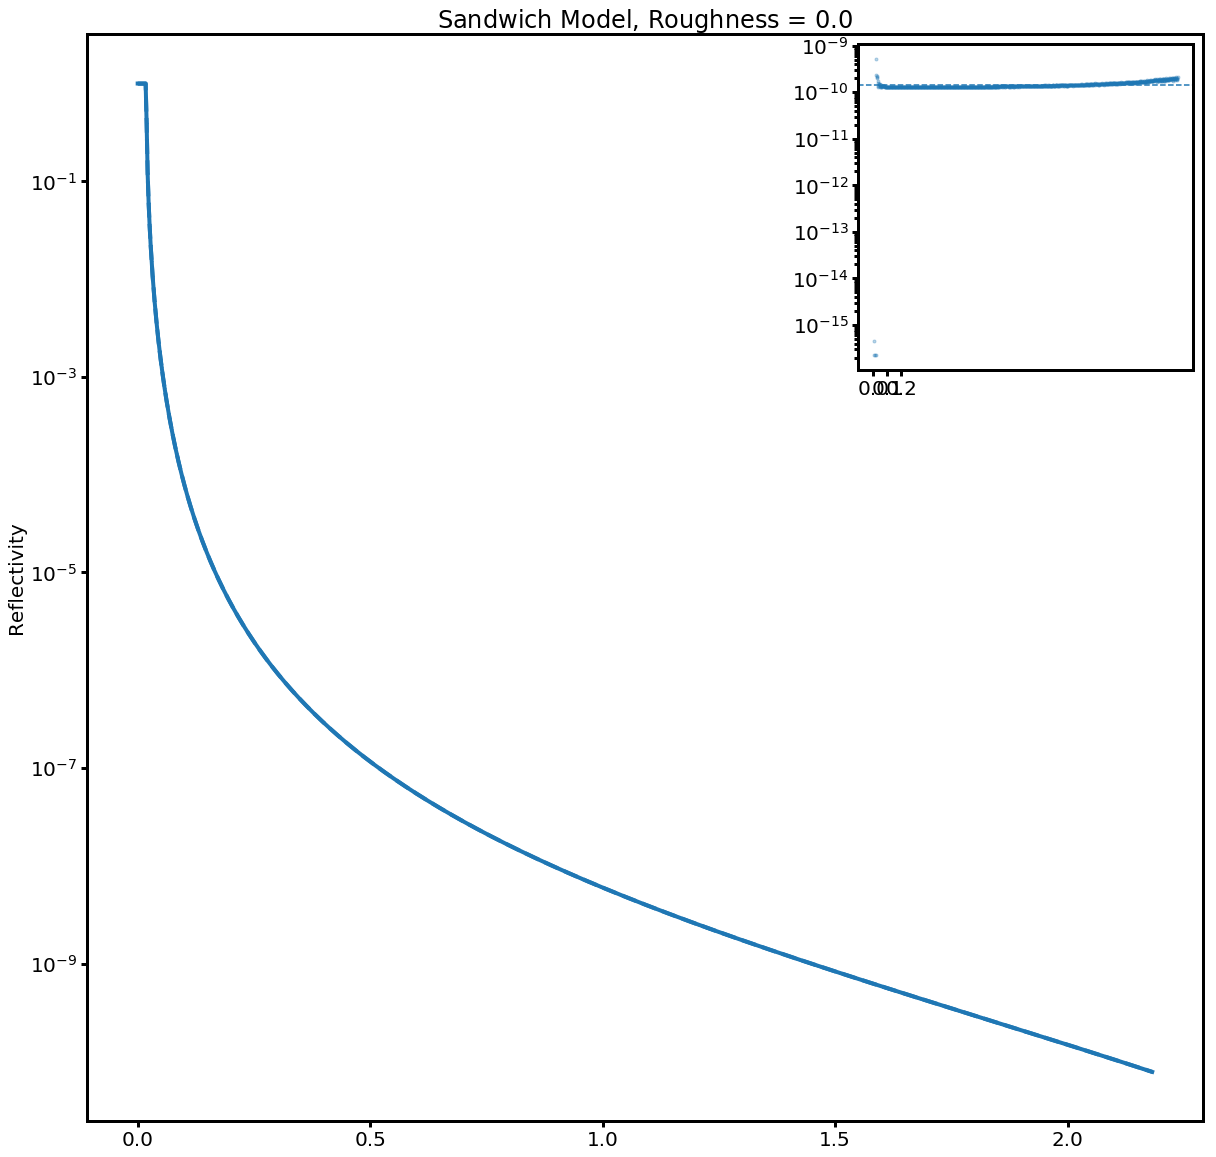

In [7]:
run_sandwich_model(1.0,0.0)

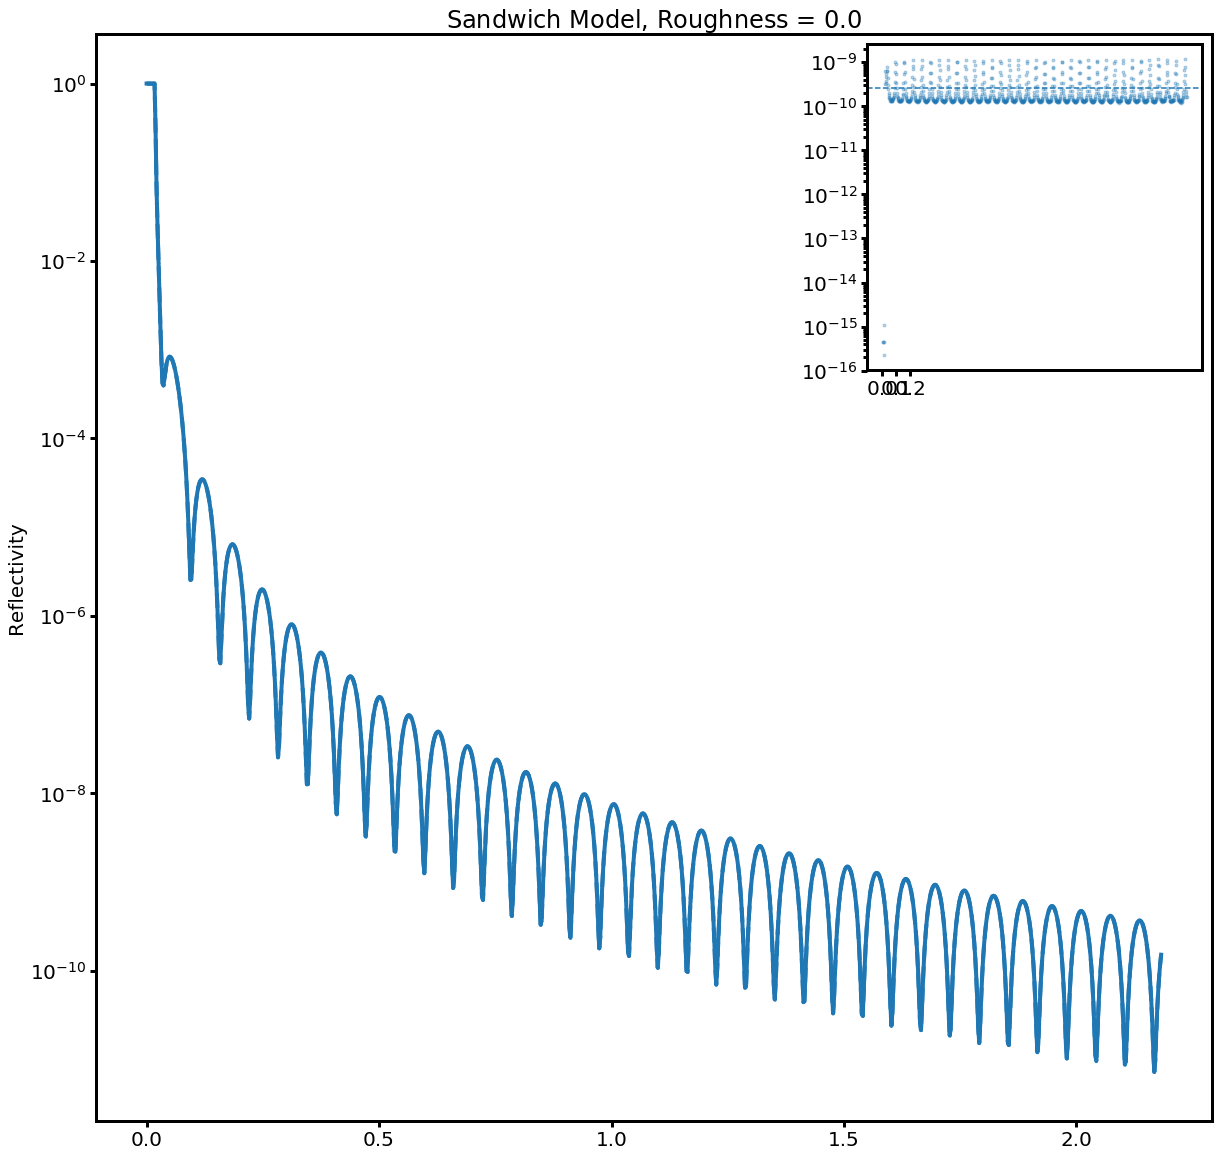

In [8]:
run_sandwich_model(100.0,0.0)

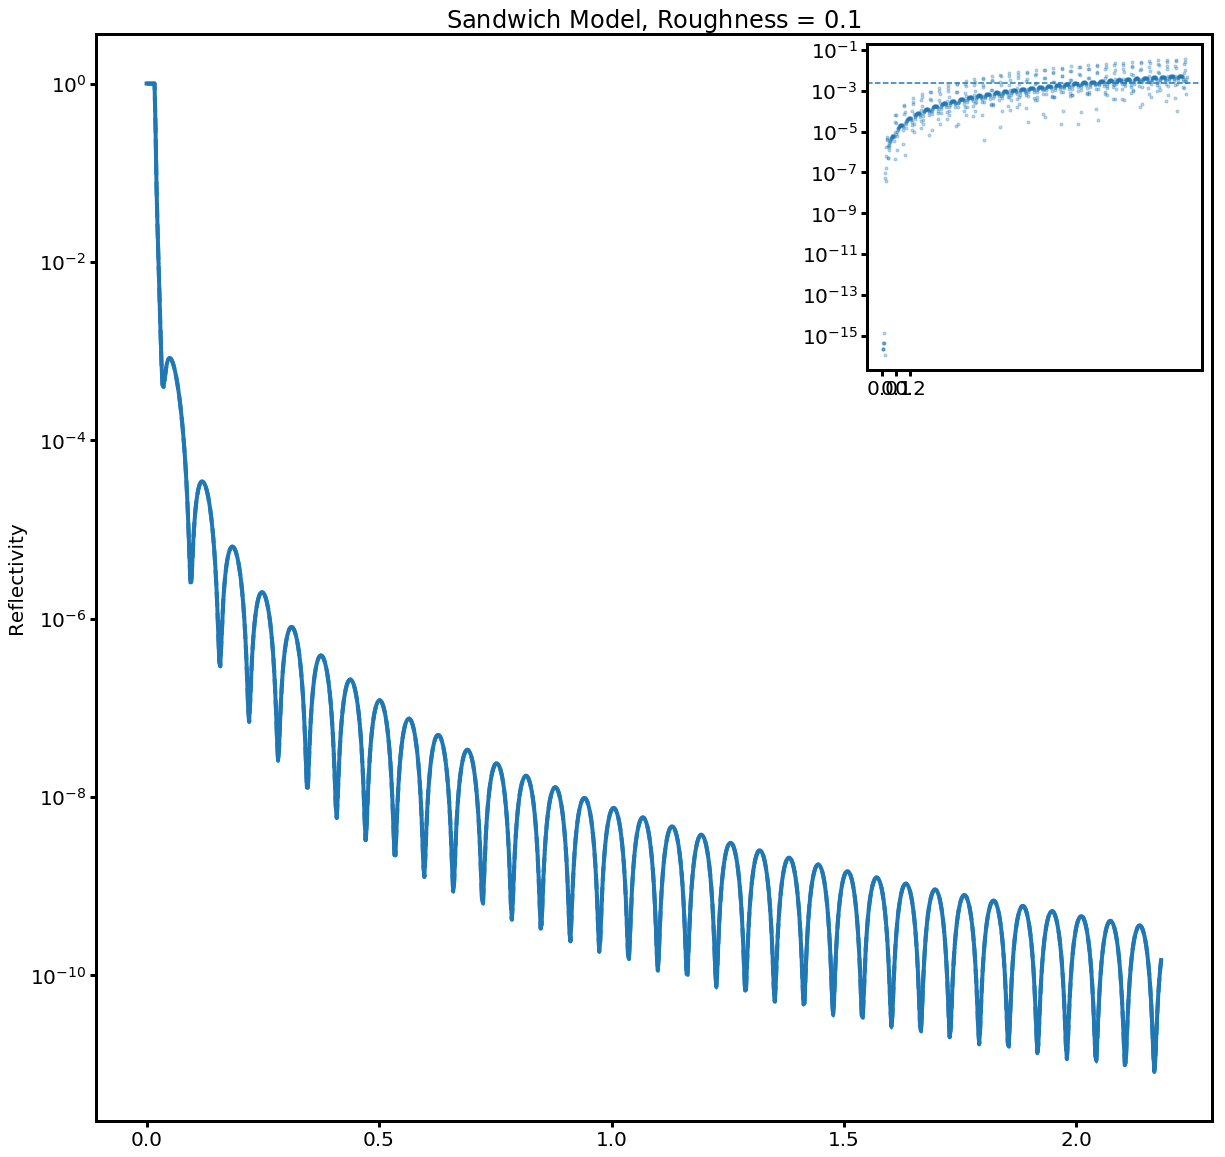

In [9]:
run_sandwich_model(100.0,0.1)

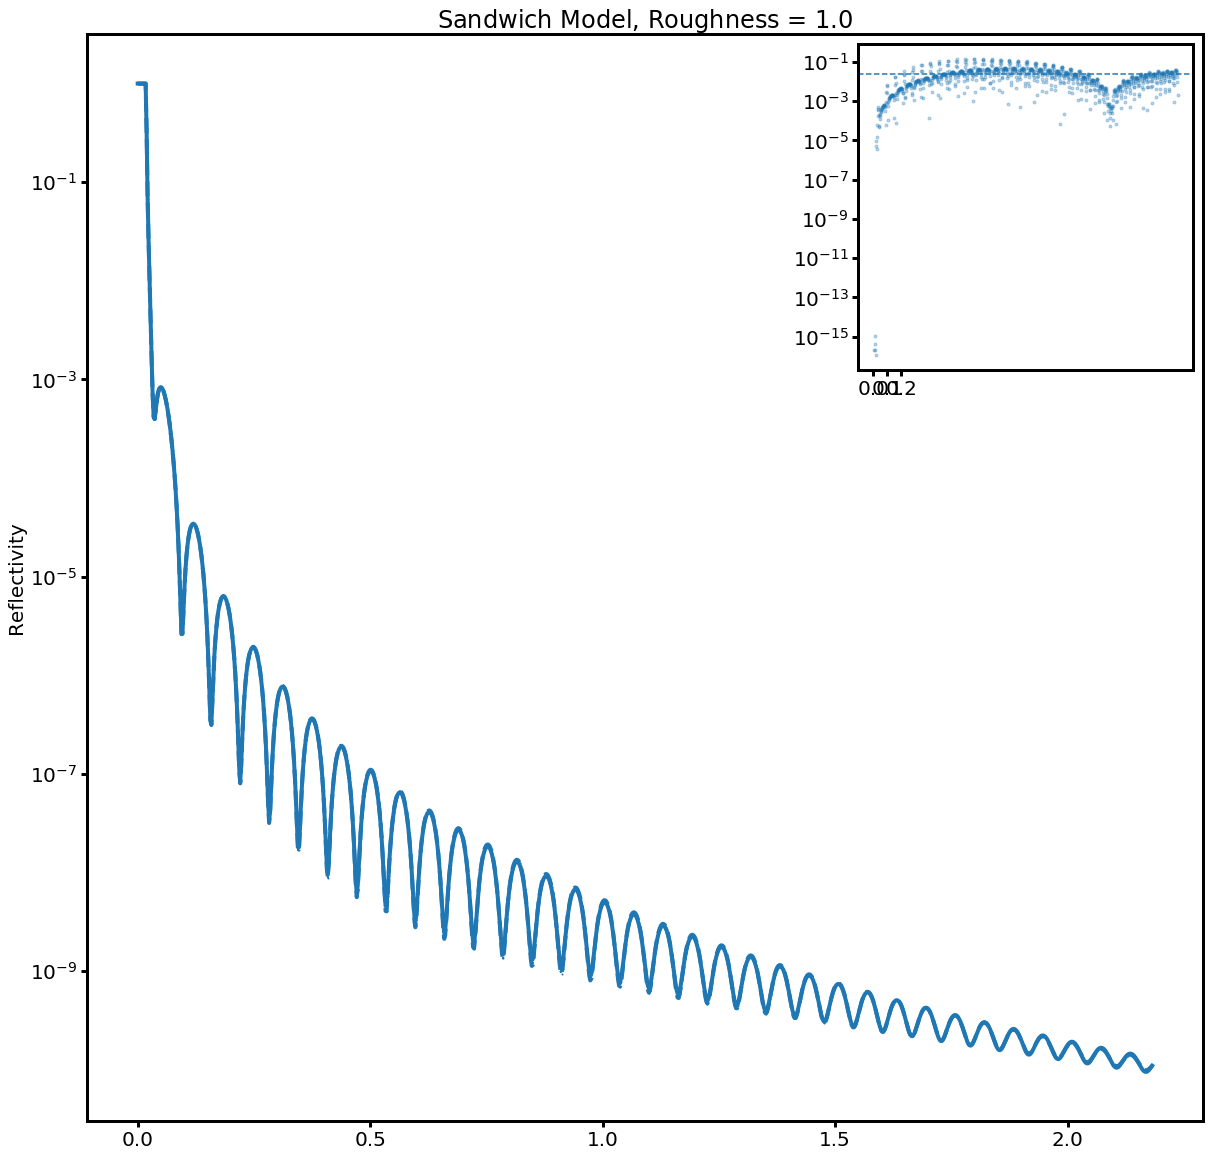

In [10]:
run_sandwich_model(100.0,1.0)